In [1]:
import dolphindb as ddb
import torch
import torch.nn as nn
from net import SimpleNet
from tqdm import tqdm
import os

from dolphindb_tools.dataloader import DDBDataLoader

In [4]:
import dolphindb_tools
dolphindb_tools.__version__, ddb.__version__, torch.__version__

('0.1-alpha1', '2.0.11.0', '1.10.1+cu111')

In [186]:
# 创建session
s = ddb.session()
s.connect("127.0.0.1", 11281, "admin", "123456")

True

In [187]:
dbPath = "dfs://ai_dataloader"
tbName = "wide_factor_table"
t1 = s.loadTable(tableName=tbName,dbPath=dbPath)

In [177]:
t1.colNames

['security_code',
 'trade_time',
 'close',
 'close1',
 'close2',
 'close3',
 'close4',
 'close5',
 'close6',
 'close7',
 'close8',
 'close9',
 'open',
 'open1',
 'open2',
 'open3',
 'open4',
 'open5',
 'open6',
 'open7',
 'open8',
 'open9',
 'high',
 'high1',
 'high2',
 'high3',
 'high4',
 'high5',
 'high6',
 'high7',
 'high8',
 'high9',
 'low',
 'low1',
 'low2',
 'low3',
 'low4',
 'low5',
 'low6',
 'low7',
 'low8',
 'low9',
 'vwap',
 'vwap1',
 'vwap2',
 'vwap3',
 'vwap4',
 'vwap5',
 'vwap6',
 'vwap7',
 'vwap8',
 'vwap9',
 'vol',
 'vol1',
 'vol2',
 'vol3',
 'vol4',
 'vol5',
 'vol6',
 'vol7',
 'vol8',
 'vol9',
 'label']

In [178]:
len(t1.exec(['distinct trade_time']).toList()) # security_code

121

In [188]:
times = t1.select("distinct trade_time").toDF().to_numpy()

In [189]:
s = ddb.session()
s.connect("127.0.0.1", 11281, "admin", "123456")

# 加载库表
dbPath = "dfs://ai_dataloader"
tbName = "wide_factor_table"
t1 = s.loadTable(tableName=tbName,dbPath=dbPath)

symbols = t1.exec(['distinct security_code']).toList().tolist()
symbols = ["`"+i for i in symbols]
# symbols = ["`000004"]
times = t1.exec(['distinct trade_time']).toList().tolist()
times = [i.strftime("%Y.%m.%d") for i in times]
times = list(set(times))

# splitTS = "2023.04.21 13:00:00"
sql = f"""select * from loadTable("{dbPath}", "{tbName}")"""

tt = s.run(sql)
tt.shape

(594837, 63)

In [190]:
dataloader = DDBDataLoader(
        s, sql, targetCol=["label"], batchSize=128, shuffle=False,
        windowSize=[1, 1], windowStride=[1, 1],
        # repartitionCol="date(trade_time)", repartitionScheme=times,
        groupCol="security_code", groupScheme=symbols,
        # seed=0,
        excludeCol=["label"], device="cuda", offset=0,
        # prefetchBatch=5, prepartitionNum=2
    )

In [191]:
torch.set_default_tensor_type(torch.DoubleTensor)

model = SimpleNet(features_in=60)
model = model.to("cuda")
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [11]:
for parameter in model.parameters():
    print(parameter)

Parameter containing:
tensor([[[ 0.1746, -0.1128,  0.1813, -0.1519, -0.0331,  0.1454,  0.0631,
           0.1459,  0.1303, -0.2823]]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.0503], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[-0.0358, -0.2120, -0.1242, -0.3151, -0.2504, -0.1350,  0.2388,
           0.2630,  0.2091, -0.1849]]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.1598], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 7.9276e-02,  1.9781e-01, -2.2259e-01, -2.3677e-01,  1.9443e-01,
         -1.5528e-01, -2.2741e-01,  2.3259e-01, -8.9684e-02, -2.2359e-01,
         -5.1812e-02, -1.4705e-01, -2.0611e-01, -2.4668e-01,  2.2785e-01],
        [-1.9564e-02, -2.3292e-01, -3.2589e-02, -2.1188e-01,  4.9809e-03,
         -1.2692e-02,  2.5805e-01,  3.1228e-02,  1.9509e-01,  1.8071e-01,
         -6.2896e-02, -6.6856e-03,  9.2432e-02,  2.0156e-01,  1.2044e-01],
        [ 1.8671e-01, -1.5858e-01, 

In [183]:
epoch = 1
model.train()
for _ in range(epoch):
    for i, (x, y) in enumerate(tqdm(dataloader, mininterval=1)):
        
        if i >= 10:
            break
        x = x.to("cuda")
        y = y.to("cuda")
        y_pred = model(x)

10it [00:00, 30.11it/s]


In [193]:
epoch = 1
model.train()
for _ in range(epoch):
    # for x, y in tqdm(dataloader, mininterval=1):
    for i, (x, y) in enumerate(dataloader):
        if (i % 500) == 0:
            print(f"{i} items proccessed...")
        x = x.to("cuda")
        y = y.to("cuda")
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

0 items proccessed...
500 items proccessed...
1000 items proccessed...
1500 items proccessed...
2000 items proccessed...
2500 items proccessed...


Exception ignored in: <bound method DataManager.__del__ of <dolphindb_tools.dataloader.datamanager.DataManager object at 0x7f895f22ba58>>
Traceback (most recent call last):
  File "/home/wangzirui/.local/lib/python3.6/site-packages/dolphindb_tools/dataloader/datamanager.py", line 56, in __del__
    self.exit()
  File "/home/wangzirui/.local/lib/python3.6/site-packages/dolphindb_tools/dataloader/datamanager.py", line 63, in exit
    self.join()
  File "/home/wangzirui/.local/lib/python3.6/site-packages/dolphindb_tools/dataloader/datamanager.py", line 51, in join
    self.back_thread.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


3000 items proccessed...
3500 items proccessed...
4000 items proccessed...
4500 items proccessed...


In [145]:
i = 0
x[i], y[i], y_pred[i]

(tensor([[1.0000, 0.9997, 1.0009, 1.0012, 1.0027, 1.0033, 1.0033, 0.9988, 0.9988,
          0.9988, 0.9997, 1.0009, 1.0012, 1.0027, 1.0027, 1.0033, 1.0030, 0.9982,
          0.9988, 0.9988, 1.0009, 1.0009, 1.0012, 1.0027, 1.0027, 1.0036, 1.0033,
          1.0000, 1.0000, 0.9991, 0.9997, 0.9997, 1.0000, 1.0012, 1.0027, 1.0033,
          1.0030, 0.9979, 0.9976, 0.9988, 1.0002, 1.0006, 1.0003, 1.0021, 1.0027,
          1.0033, 1.0033, 0.9992, 0.9985, 0.9989, 1.0000, 1.8394, 0.6892, 0.1889,
          0.2682, 0.5125, 0.3441, 1.7545, 5.6780, 1.2411]], device='cuda:0'),
 tensor([[-0.3667]], device='cuda:0'),
 tensor([[-0.0244]], device='cuda:0', grad_fn=<SelectBackward0>))

In [31]:
def constructDataLoader():
    s = ddb.session()
    s.connect("127.0.0.1", 11281, "admin", "123456")
    # 加载库表
    dbPath = "dfs://ai_dataloader"
    tbName = "wide_factor_table"
    t1 = s.loadTable(tableName=tbName,dbPath=dbPath)
    symbols = t1.exec(['distinct security_code']).toList().tolist()
    symbols = ["`"+i for i in symbols]
    times = t1.exec(['distinct trade_time']).toList().tolist()
    times = [i.strftime("%Y.%m.%d") for i in times]
    times = list(set(times))
    
    splitTS = "2023.04.21 13:00:00"
    sql = f"""select * from loadTable("{dbPath}", "{tbName}") where trade_time >= {splitTS} """
    
    dataloader = DDBDataLoader(
        s, sql, targetCol=["label"], batchSize=64, shuffle=True,
        windowSize=[1, 1], windowStride=[1, 1],
        repartitionCol="date(trade_time)", repartitionScheme=times,
        groupCol="security_code", groupScheme=symbols,
        seed=0,
        excludeCol=["label"], #device="cuda",
        prefetchBatch=5, prepartitionNum=3
    )
    return dataloader

In [32]:
dataloader = constructDataLoader()
torch.set_default_tensor_type(torch.DoubleTensor)
model = SimpleNet(features_in=60)
model.load_state_dict(torch.load("./models/simple_model.pth"))

<All keys matched successfully>

In [33]:
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(dataloader, mininterval=1)):
        if i > 1:
            break
        # x = x.to("cuda")
        y_pred = model(x)
        print(x[0])
        print(y_pred[0])
        print(type(y_pred))

2it [00:00, 10.71it/s]

tensor([[1.0000, 0.9989, 0.9989, 0.9966, 0.9966, 0.9943, 0.9954, 0.9977, 0.9989,
         0.9989, 0.9989, 0.9989, 0.9966, 0.9966, 0.9943, 0.9954, 0.9977, 0.9989,
         0.9989, 0.9989, 1.0000, 0.9989, 0.9989, 0.9966, 0.9966, 0.9954, 0.9989,
         1.0000, 0.9989, 0.9989, 0.9989, 0.9989, 0.9966, 0.9954, 0.9943, 0.9943,
         0.9954, 0.9977, 0.9977, 0.9989, 0.9996, 0.9989, 0.9983, 0.9965, 0.9960,
         0.9949, 0.9959, 0.9989, 0.9983, 0.9989, 1.0000, 1.1618, 0.7059, 1.0809,
         1.2868, 1.9485, 6.7206, 1.8162, 0.6985, 0.9853]])
tensor([[0.1389]])
<class 'torch.Tensor'>
tensor([[1.0000, 1.0022, 1.0004, 1.0007, 1.0026, 1.0022, 1.0022, 1.0037, 1.0048,
         1.0055, 1.0011, 1.0004, 1.0007, 1.0029, 1.0022, 1.0022, 1.0033, 1.0048,
         1.0055, 1.0062, 1.0011, 1.0022, 1.0007, 1.0029, 1.0026, 1.0029, 1.0033,
         1.0055, 1.0059, 1.0062, 1.0000, 1.0004, 1.0000, 1.0007, 1.0018, 1.0018,
         1.0018, 1.0037, 1.0048, 1.0055, 1.0005, 1.0007, 1.0004, 1.0017, 1.0022,
        

In [5]:
import mmap
import pickle

import numpy as np
import torch
import torch.nn as nn
from net import SimpleNet, MultiChannNet
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from prepare import prepare_index
import os


class MyDataset(Dataset):
    def __init__(self, block_size, ):
        with open("./datas/index.pkl", 'rb') as f:
            self.index_list = pickle.load(f)

        self.data_n = 10*block_size # len(self.index_list)
        self.block_size = block_size

        symbols, times = prepare_index.get_symbols_times()
        symbols = symbols[:10]


        mp_dict = dict()

        for id, symbol in enumerate(symbols):
            for t in times:
                if id >= 1000:
                    mp_dict[f"datas/{symbol}-{t}.bin"] = mp_dict[f"datas/{symbols[id % 1000]}-{t}.bin"]
                    continue
                f = open(f"./datas/{symbol}-{t}.bin", 'rb')
                mp_f = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)
                mp_dict[f"datas/{symbol}-{t}.bin"] = [f, mp_f]
        self.mp_dict = mp_dict
        self.symbols = symbols
        self.times = times
        

    def __len__(self):
        return self.data_n

    def __del__(self):
        for id, symbol in enumerate(self.symbols):
            if id >= 10:
                continue
            for t in self.times:
                f, mp_f = self.mp_dict[f"datas/{symbol}-{t}.bin"]
                mp_f.close()
                f.close()
    
    def __getitem__(self, index):
        x_infos = self.index_list[index]["x"]
        y_infos = self.index_list[index]["y"]
        x_datas = []
        y_datas = []
        for x_info in x_infos:
            f, mp_f = self.mp_dict[x_info[0]]
            mp_f.seek( x_info[1] *8*61)
            data = mp_f.read(((x_info[2]+1) - x_info[1])*8*61)
            data = np.frombuffer(data, dtype=np.float64)
            x_datas.append(data[:60].reshape(-1, 60))
            y_datas.append(data[60:].reshape(-1, 1))
        x_datas = np.concatenate(x_datas, axis=0)
        # y_datas = []
        # for y_info in y_infos:
        #     f, mp_f = self.mp_dict[y_info[0]]
        #     mp_f.seek(y_info[1]*8*1)
        #     data = mp_f.read((y_info[2] - y_info[1])*8*1)
        #     data = np.frombuffer(data, dtype=np.float64)
        #     data = data.reshape(-1, 1)
        #     y_datas.append(data)
        y_datas = np.concatenate(y_datas, axis=0)
        return x_datas, y_datas

def get_model(model_name):
    if model_name == "simple_model":
        model = SimpleNet(features_in=60)
    elif model_name == "multichann_model":
        model = MultiChannNet(features_in=6)
    
    model = model.to("cuda")
    return model

def train():
    torch.set_default_tensor_type(torch.DoubleTensor)
    model_name = "multichann_model"
    model = get_model(model_name)

    loss_fn = nn.MSELoss()
    loss_fn = loss_fn.to("cuda")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    dataset = MyDataset(110)
    dataloader = DataLoader(
        dataset, batch_size=128, shuffle=False, num_workers=4,
        pin_memory=True, # pin_memory_device="cuda",
        prefetch_factor=5,
    )

    epoch = 1
    train_losses = []
    model.train()
    for _ in range(epoch):
        for x, y in tqdm(dataloader, mininterval=1):
            x = x.to("cuda")
            y = y.to("cuda")
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.data)
        
    os.makedirs("./models/", exist_ok=True)
    torch.save(model.state_dict(),  f"./models/{model_name}_old.pth")
    return train_losses


In [6]:
train_losses = train()

100%|██████████| 9/9 [00:01<00:00,  5.25it/s]


In [10]:
train_losses = [i.cpu().detach().numpy() for i in train_losses]

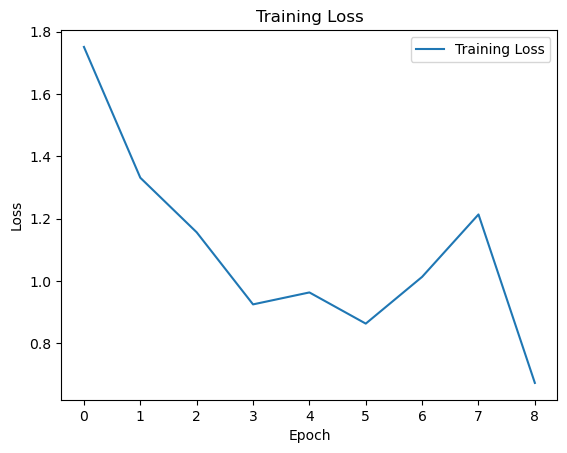

In [13]:
import matplotlib.pyplot as plt

os.makedirs("./plots", exist_ok=True)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
# plt.show()

plt.savefig("plots/multichann_model_train_loss.pdf")
